# Pretrained GAN

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Critic data

In [3]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=random.randint(10,70))

In [4]:
#il = ImageItemList.from_folder(path_hr)
#parallel(crappify, il.items)

In [29]:
bs,size=16,256
arch = models.resnet34
classes = ['crappy', 'images']
src = ImageItemList.from_folder(path, include=classes).random_split_by_pct(0.1, seed=42)

In [30]:
ll = src.label_from_folder(classes=classes)

In [31]:
data_crit = (ll.transform(get_transforms(max_zoom=2.), size=size)
       .databunch(bs=bs).normalize(imagenet_stats))

data_crit.c = 3

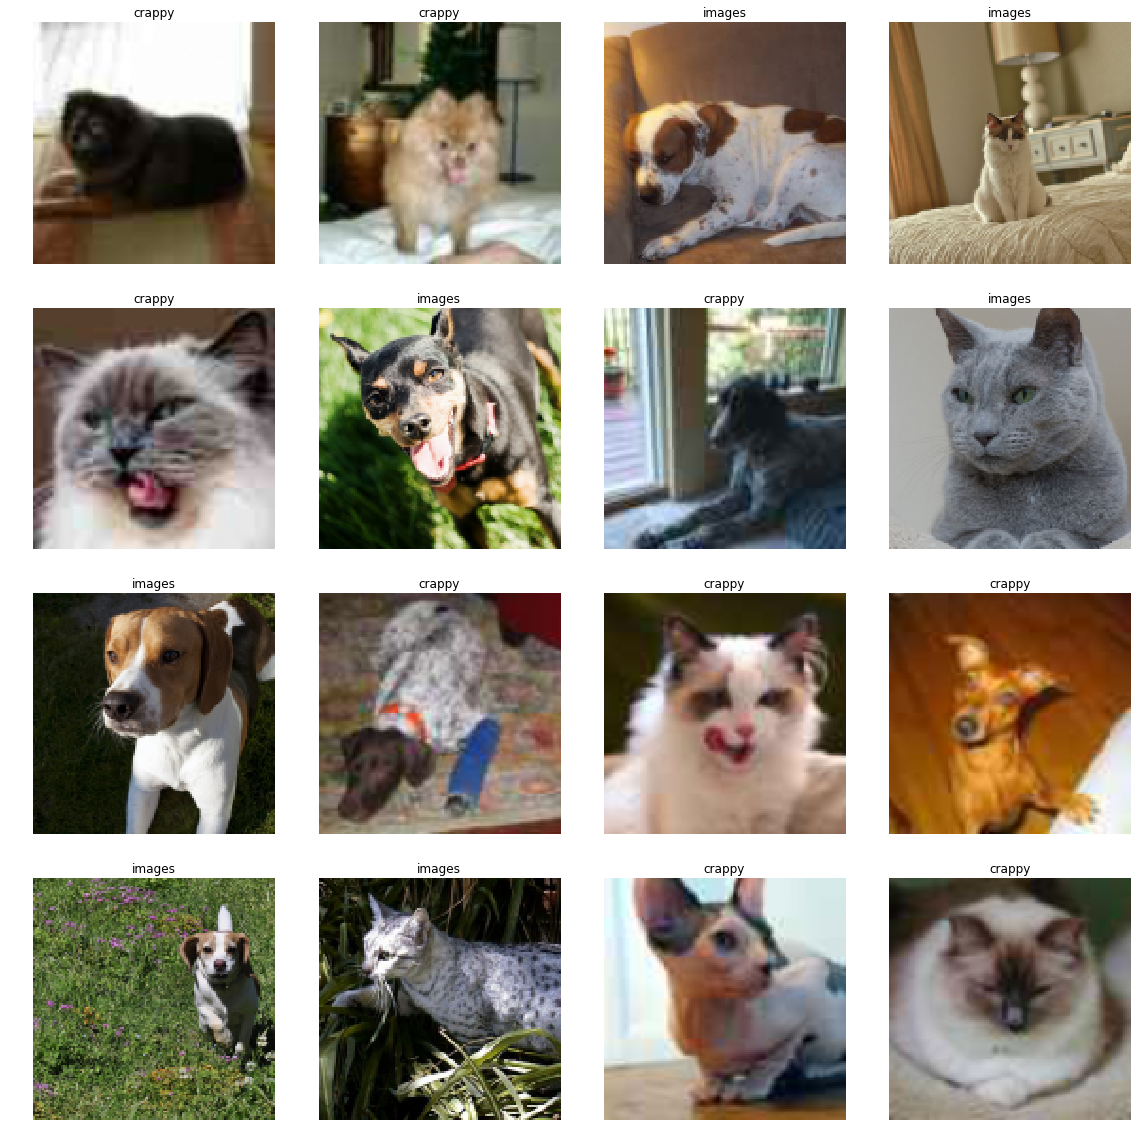

In [8]:
data_crit.show_batch(rows=4, ds_type=DatasetType.Valid)

## Train critic

In [6]:
def conv(ni:int, nf:int, ks:int=3, stride:int=1, **kwargs):
    return conv_layer(ni, nf, ks=ks, stride=stride, leaky=0.2, norm_type=NormType.Spectral, **kwargs)

def critic(n_channels:int=3, nf:int=128, n_blocks:int=3, p:int=0.05):
    layers = [
        conv(n_channels, nf, ks=4, stride=2),
        nn.Dropout2d(p/2),
        conv(nf, nf)]
    for i in range(n_blocks):
        layers += [
            nn.Dropout2d(p),
            conv(nf, nf*2, ks=4, stride=2, self_attention=(i==0))]
        nf *= 2
    layers += [
        conv(nf, 1, ks=4, bias=False, padding=0, use_activ=False),
        nn.AdaptiveMaxPool2d(1),
        Flatten(full=True)]
    return nn.Sequential(*layers)

In [10]:
learn_critic = Learner(data_crit, critic(), metrics=accuracy_thresh, loss_func=BCEWithLogitsFlat())

In [11]:
learn_critic.fit_one_cycle(8, 1e-3)

In [12]:
learn_critic.save('critic-pre')

## Pre-train generator

In [32]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [33]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [34]:
data_gen = get_data(bs,size)

In [10]:
wd = 1e-3

In [17]:
learn_gen = unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Spectral, self_attention=True, loss_func=MSELossFlat())

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 63185238.37it/s]


In [18]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [19]:
learn_gen.unfreeze()

In [20]:
learn_gen.fit_one_cycle(2, slice(1e-6,1e-3))

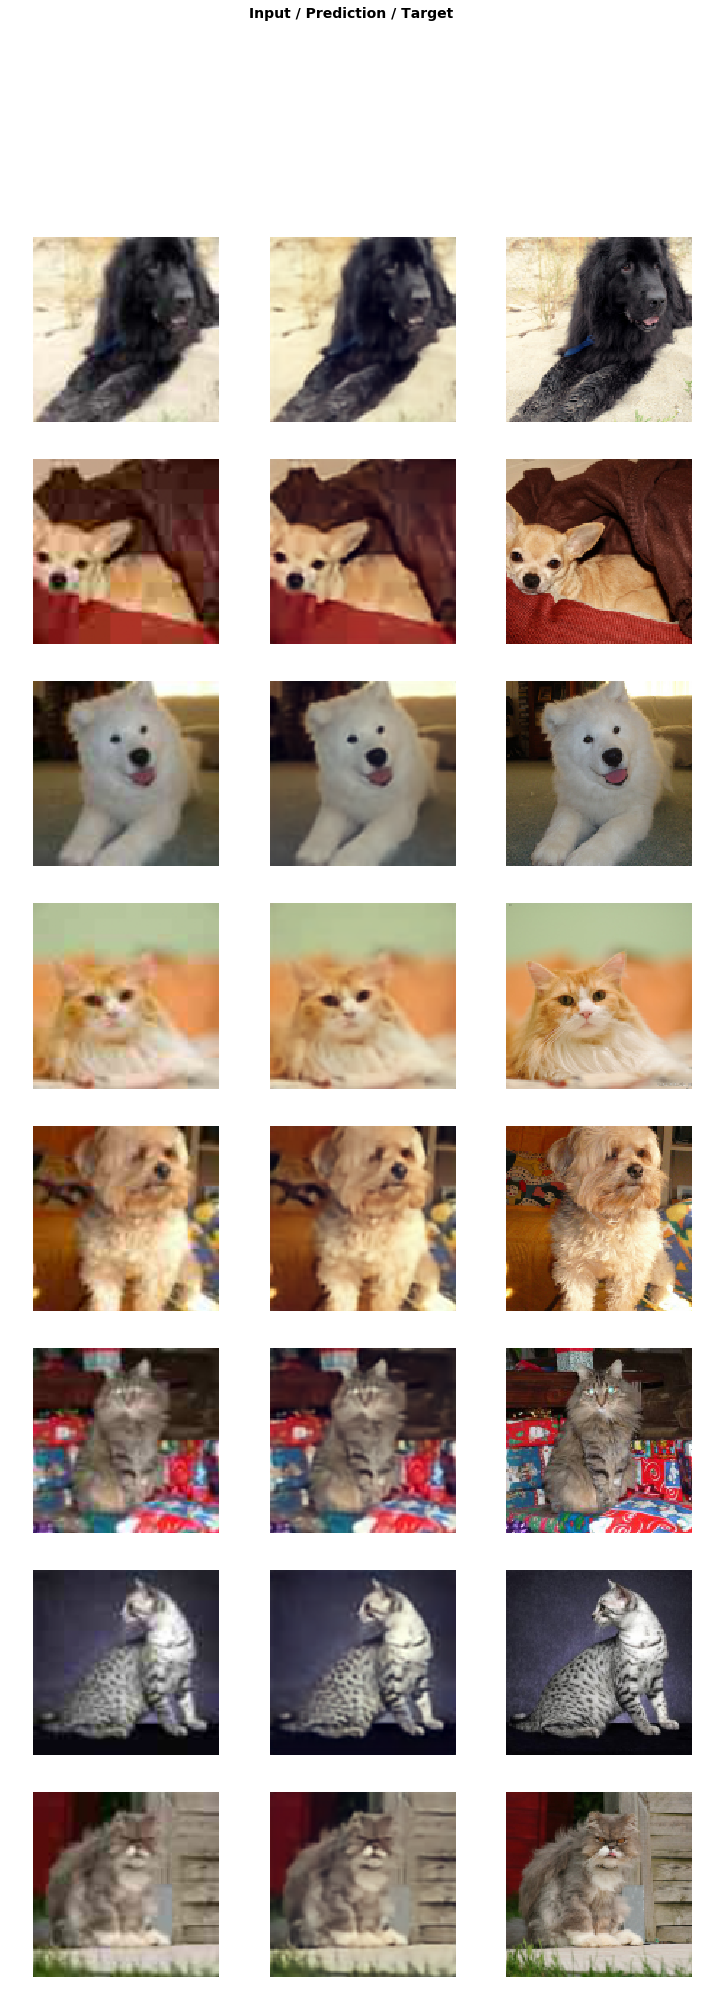

In [21]:
learn_gen.show_results(rows=8)

In [22]:
learn_gen.save('gen-pre')

## GAN

In [11]:
class GANModule(nn.Module):
    "Wrapper around a `generator` and a `critic` to create a GAN."
    def __init__(self, generator:nn.Module=None, critic:nn.Module=None, gen_mode:bool=False):
        super().__init__()
        self.gen_mode = gen_mode
        if generator: self.generator,self.critic = generator,critic
    
    def forward(self, *args):
        return self.generator(*args) if self.gen_mode else self.critic(*args)

    def switch(self, gen_mode:bool=None):
        "Put the model in generator mode if `gen_mode`, in critic mode otherwise."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode

- Generate real/fake in DL and use std BCE?

In [12]:
class GANLoss(GANModule):
    def __init__(self, loss_funcC:Callable, loss_funcG:Callable, gan_model:GANModule):
        super().__init__()
        self.loss_funcC,self.loss_funcG,self.gan_model = loss_funcC,loss_funcG,gan_model
        
    def generator(self, output, target):
        # we're training the generator, by getting the critic to output large (real) predictions
        # `output` is fake output from `gan_model.generator`
        fake_pred = self.gan_model.critic(output)
        # in a basic GAN this will just take the mean of fake_pred
        return self.loss_funcG(fake_pred, target, output)
    
    def critic(self, real_pred, input):
        # we're training the critic, by getting it to recognize which images are real vs fake
        # `real_pred` is a batch of predictions on real images
        # `input` is a batch of inputs to the generator, which we need to generate from first
        fake = self.gan_model.generator(input.requires_grad_(False)).requires_grad_(True)
        # now we can see whether the critic thinks these are real; we're trying to get it to realize they're not
        fake_pred = self.gan_model.critic(fake)
        # this will generally just take mean of the difference
        return self.loss_funcC(real_pred, fake_pred)

In [13]:
class GANTrainer(LearnerCallback):
    "Handles GAN Training."
    _order=-20
    def __init__(self, learn:Learner, switch_eval:bool=False, clip:float=None, beta:float=0.98, gen_first:bool=False):
        super().__init__(learn)
        self.switch_eval,self.clip,self.beta,self.gen_first = switch_eval,clip,beta,gen_first
        self.generator,self.critic = self.model.generator,self.model.critic

    def _set_trainable(self):
        train_model = self.generator if     self.gen_mode else self.critic
        loss_model  = self.generator if not self.gen_mode else self.critic
        requires_grad(train_model, True)
        requires_grad(loss_model, False)
        if self.switch_eval:
            train_model.train()
            loss_model.eval()
    
    def on_train_begin(self, **kwargs):
        "Create the optimizers for the generator and disciminator."
        if not getattr(self,'opt_gen',None):
            self.opt_gen = self.opt.new([nn.Sequential(*flatten_model(self.generator))])
        else: self.opt_gen.lr,self.opt_gen.wd = self.opt.lr,self.opt.wd
        if not getattr(self,'opt_critic',None):
            self.opt_critic = self.opt.new([nn.Sequential(*flatten_model(self.critic))])
        else: self.opt_critic.lr,self.opt_critic.wd = self.opt.lr,self.opt.wd
        self.gen_mode = self.gen_first
        self.switch(self.gen_mode)
        self.closses,self.glosses = [],[]
        self.smoothenerG,self.smoothenerC = SmoothenValue(self.beta),SmoothenValue(self.beta)
        self.recorder.no_val=True
        self.recorder.add_metric_names(['gen_loss', 'disc_loss'])
        self.imgs,self.titles = [],[]
    
    def on_train_end(self, **kwargs): self.switch(gen_mode=True)
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "Clamp the weights with `self.clip`."
        if self.clip is not None:
            for p in self.critic.parameters(): p.data.clamp_(-self.clip, self.clip)
        return (last_input,last_target) if self.gen_mode else (last_target, last_input)
        
    def on_backward_begin(self, last_loss, last_output, **kwargs):
        "Record `last_loss` in the proper list."
        last_loss = last_loss.detach().cpu()
        if self.gen_mode:
            self.smoothenerG.add_value(last_loss)
            self.glosses.append(self.smoothenerG.smooth)
            self.last_gen = last_output.detach().cpu()
        else:
            self.smoothenerC.add_value(last_loss)
            self.closses.append(self.smoothenerC.smooth)
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.switch(self.gen_mode)

    def on_epoch_end(self, pbar, epoch, **kwargs):
        "Put the various losses in the recorder."
        self.recorder.add_metrics([getattr(self.smoothenerG,'smooth',None),getattr(self.smoothenerC,'smooth',None)])
#         self.imgs.append(Image(self.last_gen[0]/2 + 0.5))
#         self.titles.append(f'Epoch {epoch}')
#         pbar.show_imgs(self.imgs, self.titles)
    
    def switch(self, gen_mode:bool=None):
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        self.opt.opt = self.opt_gen.opt if self.gen_mode else self.opt_critic.opt
        self._set_trainable()
        self.model.switch(gen_mode)
        self.loss_func.switch(gen_mode)

In [14]:
@dataclass
class FixedGANSwitcher(LearnerCallback):
    n_disc_iter:Union[int,Callable]
    n_gen_iter:Union[int,Callable]
    
    def on_train_begin(self, **kwargs):
        self.n_d,self.n_g = 0,0
    
    def on_batch_end(self, iteration, **kwargs):
        if self.learn.gan_trainer.gen_mode: 
            self.n_g += 1
            n_iter,n_in,n_out = self.n_gen_iter,self.n_d,self.n_g
        else:
            self.n_d += 1
            n_iter,n_in,n_out = self.n_disc_iter,self.n_g,self.n_d
        target = n_iter if isinstance(n_iter, int) else n_iter(n_in)
        if target == n_out: 
            self.learn.gan_trainer.switch()
            self.n_d,self.n_g = 0,0

In [15]:
class AdaptiveGANStopper(LearnerCallback):
    gen_thresh = 1.
    critic_thresh = 0.1
    
    def on_train_begin(self, **kwargs): self.stop=False
    
    def on_batch_end(self, iteration, last_target, **kwargs):
        if self.gan_trainer.gen_mode: 
#             real_pred = self.gan_trainer.critic(last_target)
#             ones = real_pred.new_ones(real_pred.shape[0])
#             loss_chk = loss_critic(real_pred, ones)
#             print(loss_chk)
#             if loss_chk > 0.5: self.stop=True
            loss = self.gan_trainer.smoothenerG.smooth
            if loss < self.gen_thresh: self.stop=True
        else:
            loss = self.gan_trainer.smoothenerC.smooth
            if loss < self.critic_thresh: self.stop=True
        print(self.gan_trainer.gen_mode, loss, self.stop)
        return self.stop
    
    def on_epoch_end(self, iteration, **kwargs):
        return self.stop

In [16]:
class AdaptiveGANSwitch(LearnerCallback):
    gen_thresh = 1.
    critic_thresh = 0.5
    
    def on_train_begin(self, **kwargs): self.stop=False
    
    def on_batch_end(self, iteration, last_target, **kwargs):
        if self.gan_trainer.gen_mode: 
#             real_pred = self.gan_trainer.critic(last_target)
#             ones = real_pred.new_ones(real_pred.shape[0])
#             loss_chk = loss_critic(real_pred, ones)
#             print(loss_chk)
#             if loss_chk > 0.5: self.stop=True
            loss = self.gan_trainer.smoothenerG.smooth
            #if loss < self.gen_thresh: 
            self.gan_trainer.switch()
        else:
            loss = self.gan_trainer.smoothenerC.smooth
            if loss < self.critic_thresh: self.gan_trainer.switch()
        return self.stop
    
    def on_epoch_end(self, iteration, **kwargs):
        return self.stop

In [17]:
loss_critic = BCEWithLogitsFlat()
loss_gen    = MSELossFlat()

In [18]:
def loss_C(real_pred, fake_pred):
    ones  = real_pred.new_ones (real_pred.shape[0])
    zeros = fake_pred.new_zeros(fake_pred.shape[0])
    return (loss_critic(real_pred, ones) + loss_critic(fake_pred, zeros)) / 2

In [19]:
def loss_G(fake_pred, output, target):
    ones = fake_pred.new_ones(fake_pred.shape[0])
    gan_loss = loss_critic(fake_pred, ones)
    px_loss  = loss_gen(output, target)
    return gan_loss + px_loss * 50

## Train generator with critic loss

In [52]:
learn_crit = Learner(data_crit, critic(), loss_func=loss_critic).load('critic-pre')

In [53]:
learn_gen = unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Spectral,
                         self_attention=True, loss_func=loss_gen).load('gen-pre')

In [54]:
gan = GANModule(learn_gen.model, learn_crit.model)

In [55]:
loss_func = GANLoss(loss_C, loss_G, gan)

In [56]:
#learn = Learner(data_gen, gan, loss_func=loss_func, callback_fns=[AdaptiveGANStopper], opt_func=optim.RMSprop)
learn = Learner(data_gen, gan, loss_func=loss_func, opt_func=optim.RMSprop, wd=0,
                callback_fns=[partial(FixedGANSwitcher, n_disc_iter=5, n_gen_iter=1)])

In [57]:
trainer = GANTrainer(learn, switch_eval=True)
learn.gan_trainer = trainer
learn.callbacks.append(trainer)

In [36]:
learn.lr_find(stop_div=False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

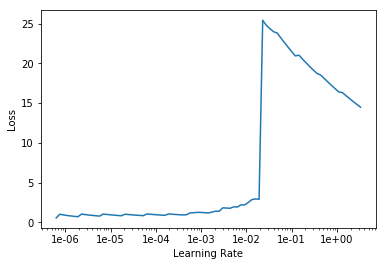

In [67]:
learn.recorder.plot()

In [58]:
learn.fit(60,1e-4)

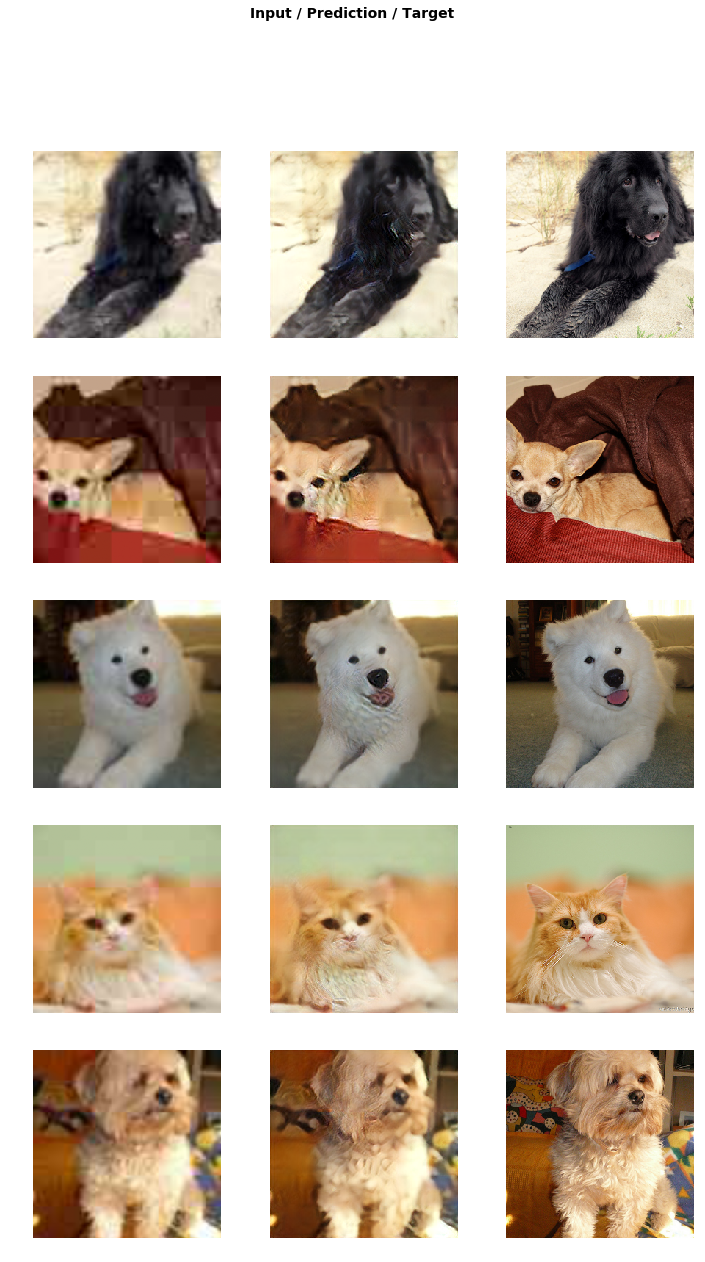

In [60]:
learn.show_results()

In [ ]:
learn.fit(60,1e-4)

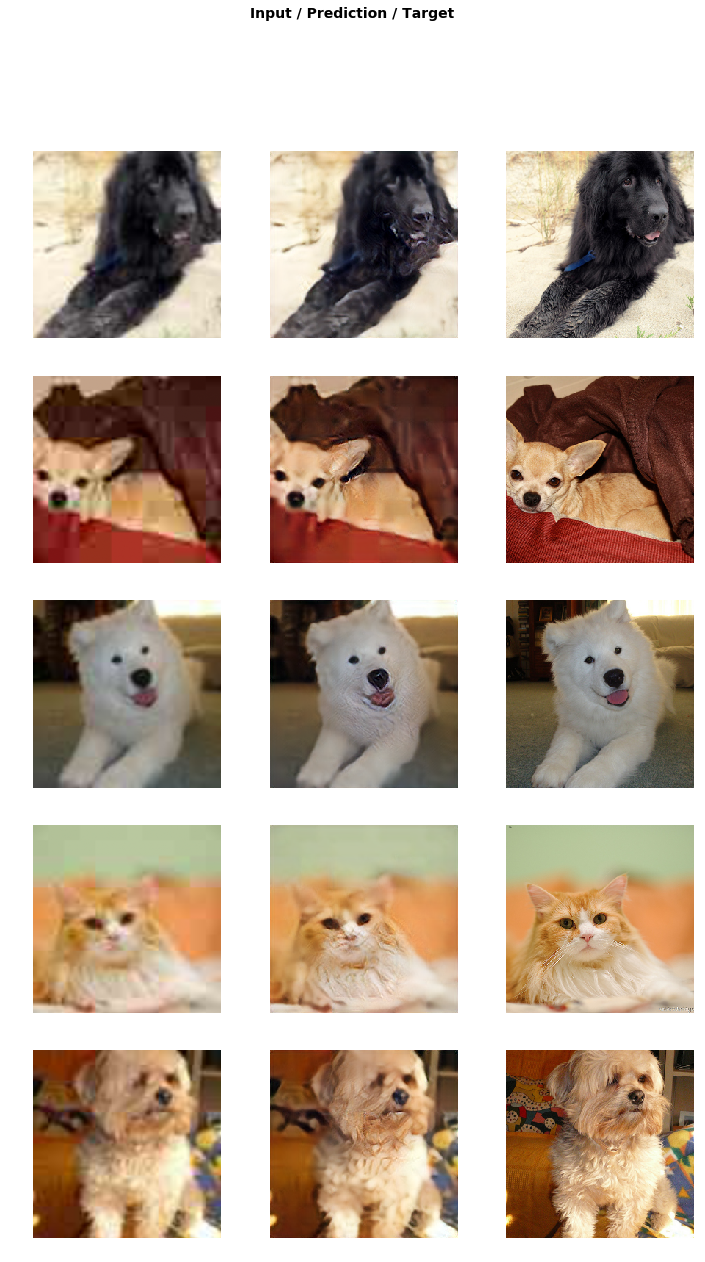

In [50]:
learn.show_results()

In [35]:
learn.data = data_gen

In [59]:
learn.save('size256f')
torch.save(trainer.opt_critic.state_dict(), path/'models'/'opt_crit_256f.pth')
torch.save(trainer.opt_gen.state_dict(), path/'models'/'opt_gen_256f.pth')

In [51]:
learn.save('size256')
torch.save(trainer.opt_critic.state_dict(), path/'models'/'opt_crit_256.pth')
torch.save(trainer.opt_gen.state_dict(), path/'models'/'opt_gen_256.pth')

In [37]:
learn.save('size128')
torch.save(trainer.opt_critic.state_dict(), path/'models'/'opt_crit_128.pth')
torch.save(trainer.opt_gen.state_dict(), path/'models'/'opt_gen_128.pth')

In [38]:
learn.fit(10,1e-4)

In [40]:
learn.fit(15,1e-4)

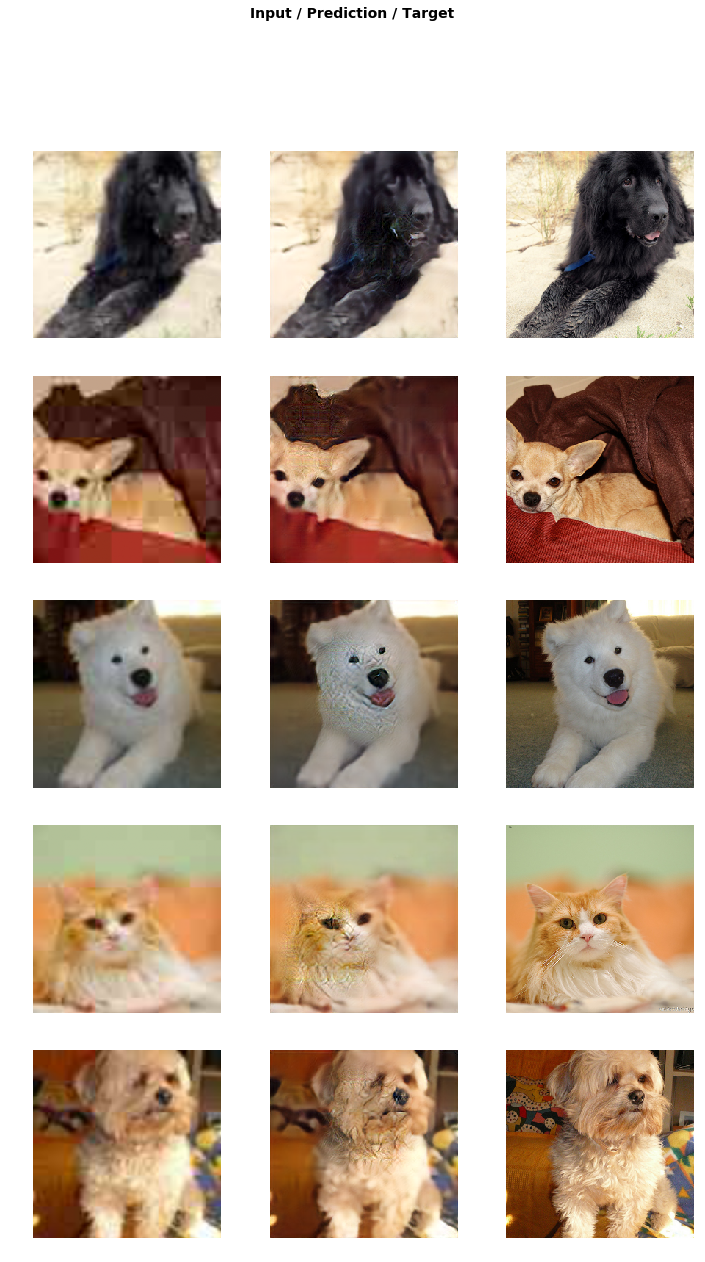

In [41]:
learn.show_results()

### stuff

In [ ]:
mc = learn_crit.model
mg = learn_gen.model

In [ ]:
learn.create_opt(lr=defaults.lr)
learn.recorder = Recorder(learn)
trainer.on_train_begin()

In [ ]:
mc.eval();
mg.eval();

In [ ]:
x,y = learn.data.one_batch(denorm=False, detach=False)

In [ ]:
trainer.switch(gen_mode=False)

In [ ]:
z = learn.model(y.clone())
learn.loss_func(z,x.clone())

In [ ]:
real_pred = learn_crit.model(y.clone())
fake = learn_gen.model(x.clone().requires_grad_(False)).requires_grad_(True)
fake_pred = learn_crit.model(fake.clone())

In [ ]:
ones = real_pred.new_ones(real_pred.shape[0])
zeros = fake_pred.new_zeros(fake_pred.shape[0])
loss_r = loss_critic(real_pred, ones)
loss_f = loss_critic(fake_pred, zeros) 
loss_c = (loss_r + loss_f) / 2

In [ ]:
loss_r,loss_f,loss_c

In [ ]:
trainer.switch(gen_mode=True)

In [ ]:
mc.eval();
mg.eval();

In [ ]:
z = learn.model(x)
learn.loss_func(z,y)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

### stuff done

In [ ]:
trainer.gen_first=True

In [ ]:
trainer.gen_first=False

In [ ]:
learn.fit_one_cycle(1, 1e-4)

In [ ]:
trainer.switch(gen_mode=True)

In [ ]:
learn.show_results()

In [ ]:
x,y = data_gen.one_batch()

In [ ]:
x = x.cuda().detach()
y = y.cuda().detach()

In [ ]:
loss_func(x, y)

In [ ]:
loss_func(y, y)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(skip_end=11)

In [ ]:
learn.fit_one_cycle(1, pct_start=0.6)

In [ ]:
learn.loss_func.mult = 100.

In [ ]:
learn.fit_one_cycle(1, slice(1e-3), pct_start=0.5)

In [ ]:
learn.show_results()

In [ ]:
learn.show_results(rows=8)

## fin

In [ ]:
class CriticLoss(nn.Module):
    def __init__(self, critic, mult=1.):
        super().__init__()
        self.critic = critic
        requires_grad(self.critic.model, False)
        self.metric_names = ['pixel','critic']
        self.mult = mult
        
    def forward(self, input, target):
        pred = self.critic.model(input)
        critic_targ = pred.new_ones(pred.shape[0])
        critic_loss = self.critic.loss_func(pred, critic_targ)*self.mult
        px_loss = F.mse_loss(input,target)
        self.metrics = dict(zip(self.metric_names, [px_loss, critic_loss]))
        return px_loss + critic_loss

In [ ]:
loss_func = CriticLoss(learn_crit, mult=0.01)